# Version 3: Basic Evolutionary Strategies (ES)
* Implement a basic version of ES to optimize the portfolio weights

In [12]:
# Importing necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from statisticscalc import analyze_convergence, validate_and_plot

In [ ]:
# Load monthly returns data
monthly_returns_df = pd.read_csv('data/monthlyreturn/monthlyreturnstocks.csv')
monthly_returns_df = monthly_returns_df.select_dtypes(include=[np.number])

# Define parameters
population_size = 50    # μ: Number of parent portfolios
offspring_size = 100    # λ: Number of offspring (λ > μ)
num_generations = 1000   # Number of generations
mutation_rate = 0.05    # Fixed mutation rate for Gaussian mutation
num_months = len(monthly_returns_df)  # Total months in the dataset
num_assets = monthly_returns_df.shape[1]  # Number of stocks/assets

# Basic ES functions
* We have added basic recombination and seleecting top individuals to generate offspring

In [ ]:
# Initialize population with each month allocated to 100% using dirichlet
# This applies a random allocation of weights between each month for the stocks. 
def initialize_population(size, num_months, num_assets):
    population = np.array([np.array([np.random.dirichlet(np.ones(num_assets)) for _ in range(num_months)]) for _ in range(size)])
    print("Initialized population shape:", population.shape)  # Should be (size, num_months, num_assets)
    return population

# Simple recombination by averaging both parents
def recombine(parent1, parent2):
    """
    Uses recombination. Averages each parents weights
    """
    return (parent1 + parent2) / 2  # Simple averaging
    

# Define mutation function
def mutate(portfolio, mutation_rate):
    """ 
    Mutation without adaptation
    """
    mutated_portfolio = portfolio + np.random.normal(0, mutation_rate, size=portfolio.shape)
    mutated_portfolio = np.abs(mutated_portfolio)
    mutated_portfolio /= mutated_portfolio.sum(axis=1, keepdims=True)  # Normalize each month to sum to 1
    return mutated_portfolio

# Fitness function with cumulative compounding
def calculate_fitness(portfolio):

    """
    Calculates each months return and uses calcultes the return cumulatively for each month
    """

    monthly_returns = monthly_returns_df.to_numpy()
    cumulative_growth = 1.0  # Start with initial growth factor of 1 (100%)

    for month in range(num_months):
        month_weights = portfolio[month]
        month_return = np.dot(month_weights, monthly_returns[month])  # Weighted return for this month
        cumulative_growth *= (1 + month_return / 100)  # Compound the cumulative growth with this month's return

    cumulative_return = (cumulative_growth - 1) * 100  # Represent as percentage
    return cumulative_return

# select top portfolios
def select_top_individuals(combined_population, combined_fitness_scores, population_size):
    """ 
    Sorts all via argsort to select the best portfolios
    """
    sorted_indices = np.argsort(combined_fitness_scores)[::-1]
    return combined_population[sorted_indices[:population_size]]


# ES Version 3

In [17]:
# Evolution Strategy loop using (μ + λ) selection
def Basic_ES_V3(population_size, offspring_size, num_generations, mutation_rate, num_months, num_assets):
    # Step 1: Initialize the parent population with random portfolios
    start_time = time.time()
    parents = initialize_population(population_size, num_months, num_assets)
    generation_plot = []  # List to track the best return in each generation

    # Step 2: Evolution loop
    for generation in range(num_generations):
        # Calculate fitness for each parent portfolio
        parent_fitness = np.array([calculate_fitness(portfolio) for portfolio in parents])

        # Step 3: Generate offspring through recombination and mutation
        offspring = []
        for _ in range(offspring_size):
            # Randomly select two parents and recombine to create a child portfolio
            parent1 = parents[np.random.randint(0, population_size)]
            parent2 = parents[np.random.randint(0, population_size)]
            child = recombine(parent1, parent2)  # Combine traits of both parents
            # Apply mutation to the child portfolio to introduce variation
            mutated_child = mutate(child, mutation_rate)
            offspring.append(mutated_child)

        offspring = np.array(offspring)  # Convert list of offspring to NumPy array

        # Calculate fitness for each offspring portfolio
        offspring_fitness = np.array([calculate_fitness(ind) for ind in offspring])

        # Step 4: Combine parents and offspring for selection
        combined_population = np.vstack((parents, offspring))  # Join parents and offspring
        combined_fitness = np.concatenate((parent_fitness, offspring_fitness))  # Combine fitness scores

        # Select the top-performing portfolios to become the next generation of parents
        parents = select_top_individuals(combined_population, combined_fitness, population_size)

        # Track the best return for the current generation
        best_return = np.max(combined_fitness)
        generation_plot.append(best_return)

        # Print progress every 100 generations
        if generation % 100 == 0:
            print(f"Generation {generation}: Best Cumulative Return = {best_return:.4f}")

    # Step 5: Identify the best portfolio after all generations
    best_portfolio = parents[np.argmax(parent_fitness)]
    best_return = np.max(parent_fitness)
    end_time = time.time() - start_time

    return best_portfolio, generation_plot, best_return, end_time


Initialized population shape: (50, 59, 20)
Generation 0: Best Cumulative Return = 180.6458
Generation 100: Best Cumulative Return = 301.2857
Generation 200: Best Cumulative Return = 301.2857
Generation 300: Best Cumulative Return = 301.2857
Generation 400: Best Cumulative Return = 309.1702
Generation 500: Best Cumulative Return = 309.1702
Generation 600: Best Cumulative Return = 314.6910
Generation 700: Best Cumulative Return = 314.6910
Generation 800: Best Cumulative Return = 314.6910
Generation 900: Best Cumulative Return = 331.8012
Convergence achieved at generation: 111
Time to convergence: 2.06 seconds
Best Return: 331.8012087655549
Total Time: 18.53 seconds
All monthly allocations sum to 1.


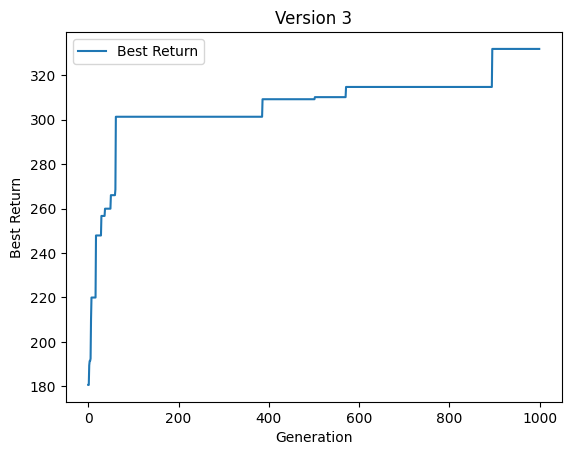

In [18]:
# Run the basic ES optimization with (μ + λ) selection
best_portfolio, generation_plot, best_return, end_time = Basic_ES_V3(population_size, offspring_size, num_generations, mutation_rate, num_months, num_assets)


analyze_convergence(generation_plot, end_time)
# Display final results
print("Best Return:", best_return)
print(f"Total Time: {end_time:.2f} seconds")
validate_and_plot(best_portfolio, generation_plot, num_months, title="Version 3", output_file="results/Version_3.png")

